## Compare LightGBM in the case of binary class (Sell, Buy)

In [1]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
import lightgbm as lgb
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_lightgbm,
    select_threshold,
)

In [2]:
METRIC = "precision"
TEST_SIZE = 200
FPR_MAX = 0.05
TIMEOUT = 600

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline LightGBM Classifier without new data

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

### Split dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [10]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-17 00:19:54,198] A new study created in memory with name: no-name-cc88e903-a78b-49d4-9aff-b7be9112c0eb


[I 2024-02-17 00:19:55,112] Trial 0 finished with value: 0.5500378612944778 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'min_sum_hessian_in_leaf': 2.2408746964386374e-05, 'feature_fraction': 0.9559495145396355, 'feature_fraction_bynode': 0.7756762966854557, 'bagging_fraction': 0.5571365665990291, 'bagging_freq': 3, 'min_child_samples': 77, 'num_grad_quant_bins': 11, 'max_depth': 7, 'extra_trees': True}. Best is trial 0 with value: 0.5500378612944778.
[I 2024-02-17 00:19:55,309] Trial 1 finished with value: 0.5355541950058379 and parameters: {'lambda_l1': 6.783994694771757e-05, 'lambda_l2': 0.005409181413953853, 'num_leaves': 237, 'min_sum_hessian_in_leaf': 1.2849522382878182e-05, 'feature_fraction': 0.9924506706839386, 'feature_fraction_bynode': 0.7937852825491334, 'bagging_fraction': 0.5351685596933026, 'bagging_freq': 3, 'min_child_samples': 79, 'num_grad_quant_bins': 11, 'max_depth': 6, 'extra_trees': True}. Best is tri

Number of finished trials: 150
Best trial:
  Value: 0.6780028220212082
  Params: 
    lambda_l1: 0.0002529044491473335
    lambda_l2: 1.0423964558447503e-06
    num_leaves: 175
    min_sum_hessian_in_leaf: 1.929137145325711e-05
    feature_fraction: 0.7839633145038547
    feature_fraction_bynode: 0.557150824657312
    bagging_fraction: 0.9241708413894586
    bagging_freq: 1
    min_child_samples: 5
    num_grad_quant_bins: 7
    max_depth: 18
    extra_trees: False


In [11]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **trial.params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [12]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.9241708413894586,
                                bagging_freq=1, extra_trees=False,
                                feature_fraction=0.7839633145038547,
                                feature_fraction_bynode=0.557150824657312,
                                lambda_l1=0.0002529044491473335,
                                lambda_l2=1.0423964558447503e-06, max_depth=18,
                                metric='average_precision', min_child_samples=5,
                                min_sum_hessian_in_leaf=1.929137145325711e-05,
                                num_grad_quant_bins=7, num_leaves=175,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [13]:
# In-sample score
pipe.score(X_train, y_train)

1.0

In [14]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       680
           1       1.00      1.00      1.00       628

    accuracy                           1.00      1308
   macro avg       1.00      1.00      1.00      1308
weighted avg       1.00      1.00      1.00      1308



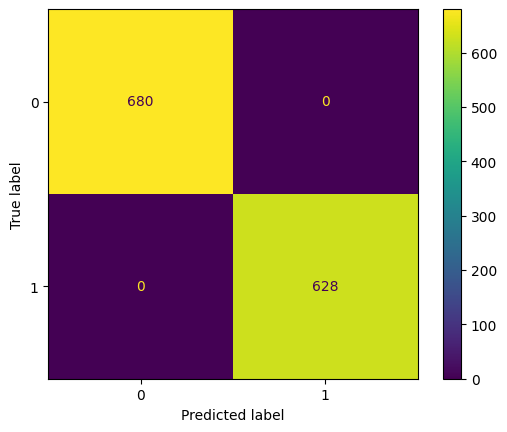

In [15]:
display_report(y_train, in_sample_preds)

In [16]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.90


In [17]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [18]:
pipe.score(X_test, y_test)

0.54

              precision    recall  f1-score   support

           0       0.50      0.96      0.66        96
           1       0.75      0.12      0.20       104

    accuracy                           0.52       200
   macro avg       0.62      0.54      0.43       200
weighted avg       0.63      0.52      0.42       200



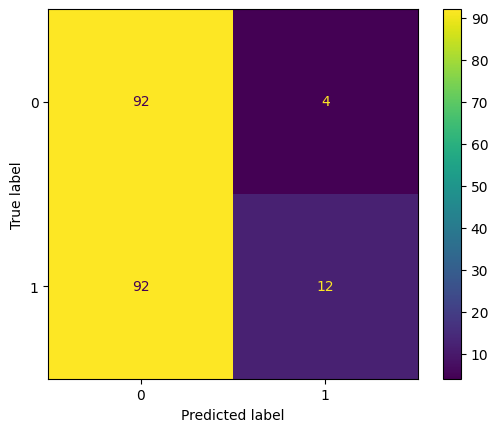

In [19]:
display_report(y_test, predictions)

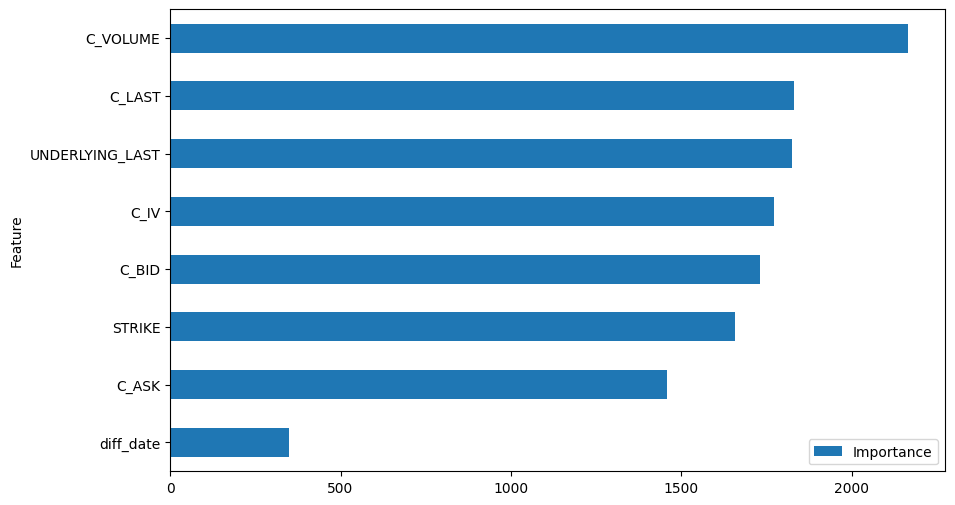

In [20]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [21]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [22]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [23]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-03-16,0,396.0,7.15,2023-04-06,409.190002,0.000000,6.040002,0.000000,6.040002
2023-03-17,1,390.0,8.89,2023-04-06,409.190002,10.300002,10.300002,10.300002,16.340005
2023-03-20,0,394.0,7.65,2023-04-06,409.190002,0.000000,7.540002,10.300002,23.880007
2023-03-21,0,399.0,8.74,2023-04-14,412.459991,0.000000,4.719991,10.300002,28.599999
2023-03-22,0,392.0,11.25,2023-04-14,412.459991,0.000000,9.209991,10.300002,37.809990
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,113.119971,492.519692
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.000000,0.309993,113.119971,492.829685
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,113.119971,493.069678


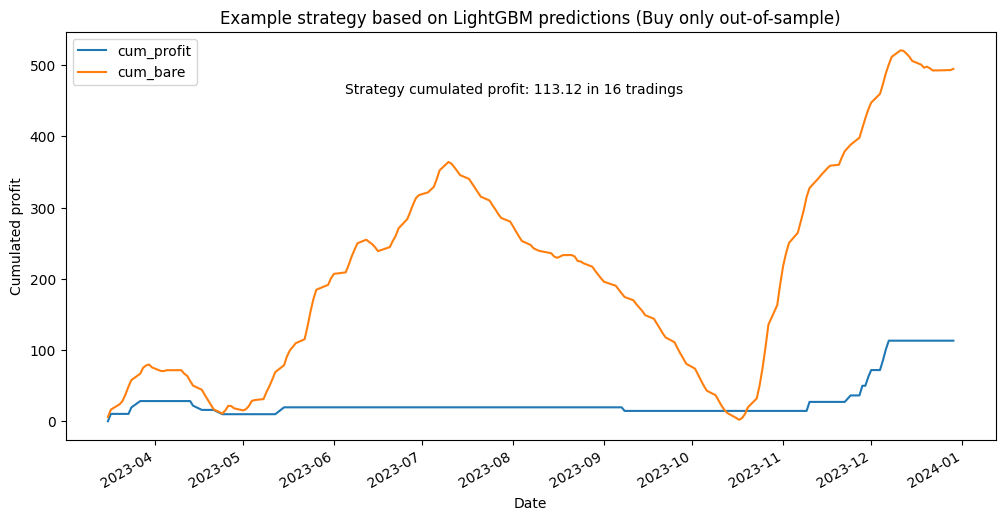

In [24]:
plot_strategy(strategy_df, "LightGBM", "(Buy only out-of-sample)")

In [25]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## LightGBM with data from MC simulation and additional features

In [26]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [27]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [29]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT * 2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-17 00:21:41,848] A new study created in memory with name: no-name-9dc3c1dc-e68a-42e2-98fe-5d3035a47371
[I 2024-02-17 00:21:43,023] Trial 0 finished with value: 0.5897375645387003 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'min_sum_hessian_in_leaf': 2.2408746964386374e-05, 'feature_fraction': 0.9559495145396355, 'feature_fraction_bynode': 0.7756762966854557, 'bagging_fraction': 0.5571365665990291, 'bagging_freq': 3, 'min_child_samples': 77, 'num_grad_quant_bins': 11, 'max_depth': 7, 'extra_trees': True}. Best is trial 0 with value: 0.5897375645387003.
[I 2024-02-17 00:21:43,316] Trial 1 finished with value: 0.5852070189439886 and parameters: {'lambda_l1': 6.783994694771757e-05, 'lambda_l2': 0.005409181413953853, 'num_leaves': 237, 'min_sum_hessian_in_leaf': 1.2849522382878182e-05, 'feature_fraction': 0.9924506706839386, 'feature_fraction_bynode': 0.7937852825491334, 'bagging_fraction': 0.5351685596933026, 'baggi

Number of finished trials: 150
Best trial:
  Value: 0.7112322462694628
  Params: 
    lambda_l1: 3.4560669008573043e-08
    lambda_l2: 0.21544143722846204
    num_leaves: 171
    min_sum_hessian_in_leaf: 0.0002772098371392397
    feature_fraction: 0.6263110668813843
    feature_fraction_bynode: 0.9406524120723705
    bagging_fraction: 0.9952251513695319
    bagging_freq: 1
    min_child_samples: 5
    num_grad_quant_bins: 4
    max_depth: 18
    extra_trees: True


In [30]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **study.best_params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [31]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.9952251513695319,
                                bagging_freq=1, extra_trees=True,
                                feature_fraction=0.6263110668813843,
                                feature_fraction_bynode=0.9406524120723705,
                                lambda_l1=3.4560669008573043e-08,
                                lambda_l2=0.21544143722846204, max_depth=18,
                                metric='average_precision', min_child_samples=5,
                                min_sum_hessian_in_leaf=0.0002772098371392397,
                                num_grad_quant_bins=4, num_leaves=171,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [32]:
# In-sample score
pipe.score(X_train, y_train)

0.9380733944954128

In [33]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       680
           1       0.94      0.93      0.94       628

    accuracy                           0.94      1308
   macro avg       0.94      0.94      0.94      1308
weighted avg       0.94      0.94      0.94      1308



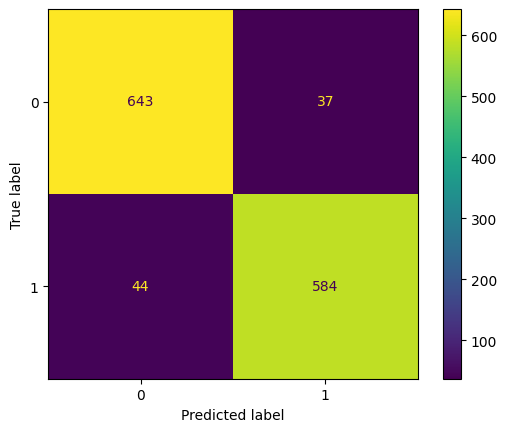

In [34]:
display_report(y_train, in_sample_preds)

In [35]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.51


In [36]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [37]:
pipe.score(X_test, y_test)

0.56

              precision    recall  f1-score   support

           0       0.54      0.58      0.56        96
           1       0.58      0.54      0.56       104

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200



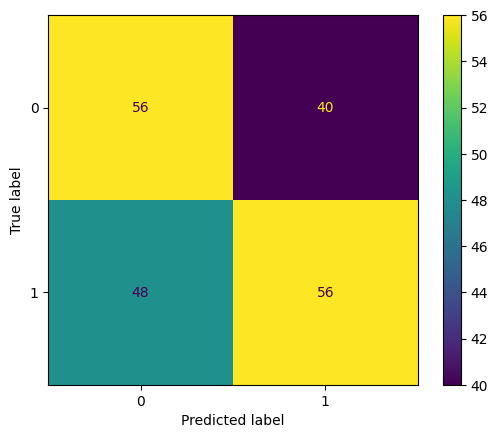

In [38]:
display_report(y_test, predictions)

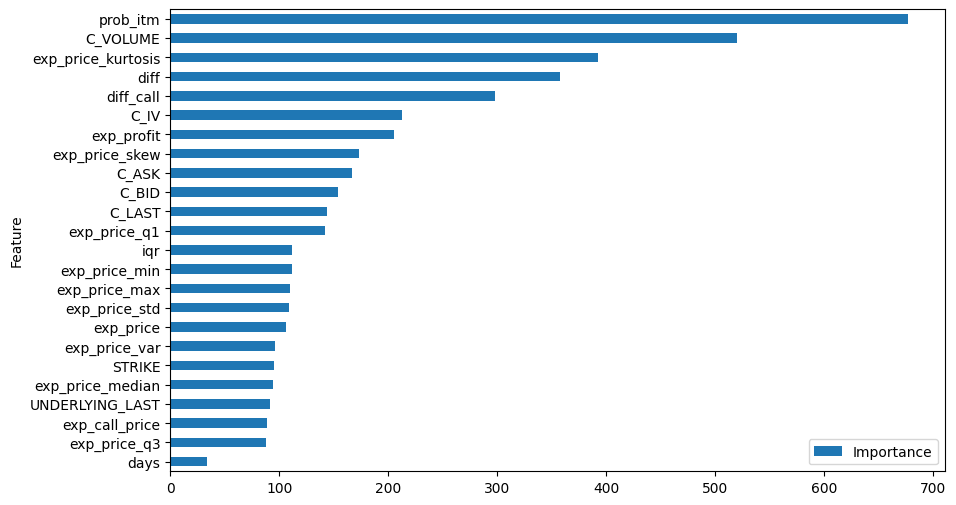

In [39]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [40]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [41]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [42]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-03-16,0,396.0,7.15,2023-04-06,409.190002,0.000000,6.040002,0.000000,6.040002
2023-03-17,1,390.0,8.89,2023-04-06,409.190002,10.300002,10.300002,10.300002,16.340005
2023-03-20,1,394.0,7.65,2023-04-06,409.190002,7.540002,7.540002,17.840005,23.880007
2023-03-21,0,399.0,8.74,2023-04-14,412.459991,0.000000,4.719991,17.840005,28.599999
2023-03-22,0,392.0,11.25,2023-04-14,412.459991,0.000000,9.209991,17.840005,37.809990
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,302.739865,492.519692
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.000000,0.309993,302.739865,492.829685
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,302.739865,493.069678


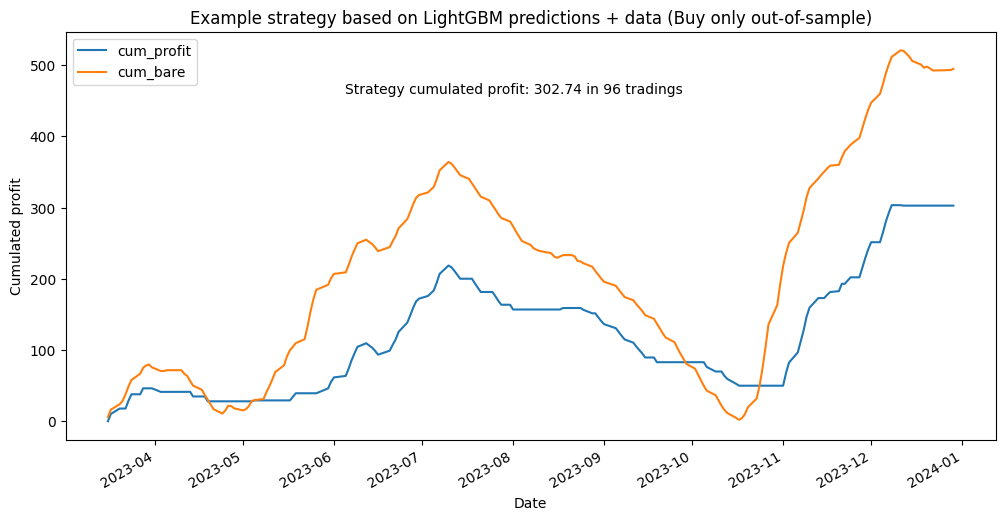

In [43]:
plot_strategy(strategy_df, "LightGBM", "+ data (Buy only out-of-sample)")

In [44]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [45]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [46]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
2,0,10.300002,1,17.840005,23.880007
5,0,10.300002,1,28.739996,48.709982
7,1,28.319985,0,37.849988,66.729965
8,0,28.319985,1,46.220000,75.099977
12,0,28.319985,1,41.210012,70.620026
...,...,...,...,...,...
172,0,27.150010,1,182.689912,360.109805
173,0,27.150010,1,192.999899,370.419791
178,0,49.779990,1,229.309873,425.289739
185,0,113.119971,1,303.399851,511.699711


In [47]:
compare_df[mask_out].shape

(88, 5)

In [48]:
compare_df.sum(axis=0)

bare_rf_pred_out          16.000000
cum_profit_out          5522.749550
mmar_rf_pred_out          96.000000
mmar_cum_profit_out    24009.583887
mmar_cum_bare_out      41758.960105
dtype: float64

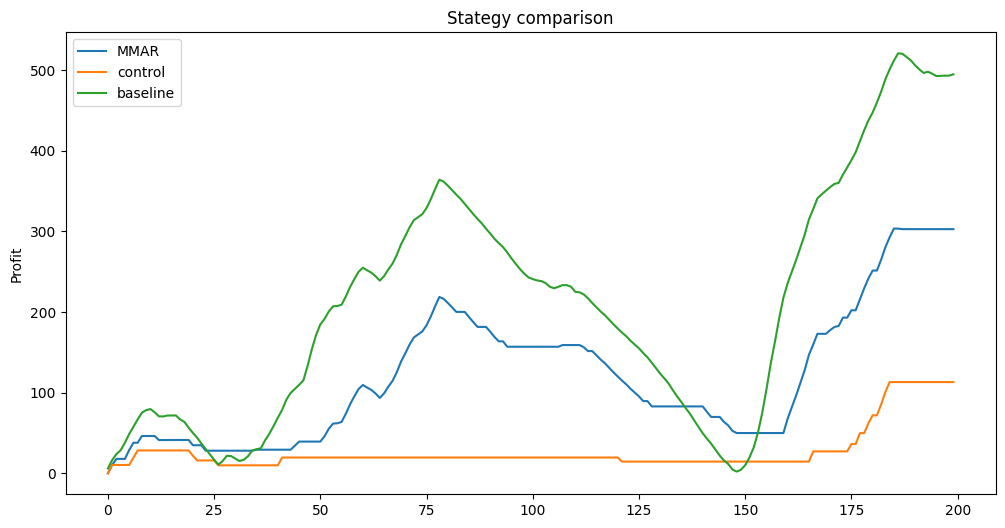

In [49]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()